# Predict Breast Cancer from Breast Histopathology Images

I will work with Kaggle dataset from Breast Histopathology Images.
The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png . Where u is the patient ID (10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

In [1]:
import glob
import os
import cv2
import numpy as np
import fnmatch
from torch.utils import data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch
from livelossplot import PlotLosses
import torch.nn.functional as F

images = glob.glob(os.getcwd() + '/data/**/*.png', recursive=True)

### Load and preprocess the data

First, I will define filters for positive and negative labels.

In [2]:
negative = '*class0.png'
positive = '*class1.png'
classZero = fnmatch.filter(images, negative)
classOne = fnmatch.filter(images, positive)

In [3]:
def load_data(list_of_images, batch_size):
    X_data = []
    y_data = []
    for img in np.random.choice(list_of_images, batch_size):
            image = cv2.imread(img)
            X_data.append(cv2.resize(image, (50,50)).transpose((2,0,1)))
            if img in classZero:
                y_data.append(0)
            elif img in classOne:
                y_data.append(1)
    return X_data, y_data

In [4]:
X_data, y_data = load_data(images, 1000)
print('number of X: %s' % str(len(X_data)))
print('number of y: %s' % str(len(y_data)))

number of X: 1000
number of y: 1000


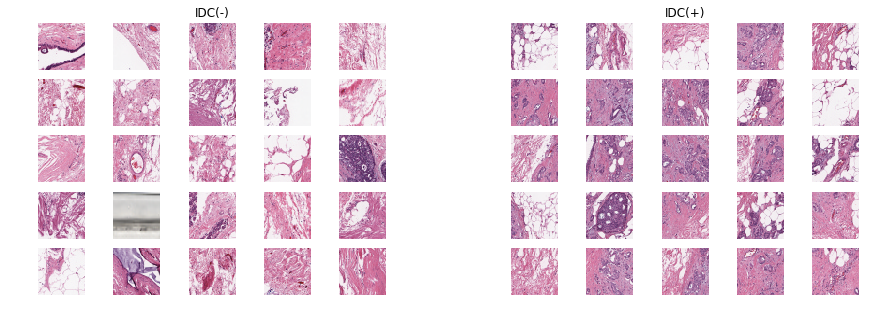

In [5]:
f = plt.figure(figsize=(15, 5))

outter = gridspec.GridSpec(1, 2, wspace=0.3, hspace=0.0)

for j, classes, name in ((0, classZero, 'IDC(-)'), (1, classOne, 'IDC(+)')):
    i = 0
    inner = gridspec.GridSpecFromSubplotSpec(5, 5,
            subplot_spec=outter[j])
    ax = f.add_subplot(outter[j])
    ax.set_title(name)
    plt.axis('off')
    for l in classes[0:25]:
        ax = f.add_subplot(inner[i])
        im = cv2.imread(l)
        im = cv2.resize(im, (50, 50)) 
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        i += 1
    j += 1

In [6]:
df = pd.DataFrame()
df["images"] = X_data
df["labels"] = y_data
images_df = df["images"]
labels_df = df["labels"]
images_df = np.array(images_df)
imgs0 = []
imgs1 = []
imgs0 = images_df[labels_df == 0] # (0 = no IDC, 1 = IDC)
imgs1 = images_df[labels_df == 1]

print(df.head())

                                              images  labels
0  [[[234, 234, 212, 210, 205, 195, 208, 221, 214...       0
1  [[[212, 200, 204, 199, 209, 200, 200, 200, 214...       0
2  [[[114, 128, 161, 178, 159, 131, 116, 112, 131...       1
3  [[[209, 216, 205, 167, 197, 201, 199, 201, 204...       0
4  [[[244, 243, 243, 227, 231, 246, 245, 243, 240...       0


Now we have a data frame thats holds all of the data. Lets eximaine it.

In [7]:
print('Total number of images: ' + str(len(images_df)))
print('Number of IDC(-) Images: ' + str(np.sum(labels_df==0)))
print('Number of IDC(+) Images: '+ str(np.sum(labels_df==1)))
print('Percentage of positive images: %' + str(100*np.mean(labels_df)))
print('Image shape (Width, Height, Channels): ' + str(images_df[0].shape))

Total number of images: 1000
Number of IDC(-) Images: 706
Number of IDC(+) Images: 294
Percentage of positive images: %29.4
Image shape (Width, Height, Channels): (3, 50, 50)


As we see, the data is unbalanced. We will try to solve this problem later.

In [8]:
def split_train_test_val(X_data, y_data, train_num=0.4, val_num=0.2):
    train_num = int(len(X_data) * train_num)
    val_num = int(len(X_data) * val_num)

    X_data = torch.Tensor(X_data)
    y_data = torch.Tensor(y_data)

    X_train = X_data[0: train_num]
    y_train = y_data[0: train_num]
    X_val = X_data[train_num: train_num + val_num]
    y_val = y_data[train_num: train_num + val_num]
    X_test = X_data[train_num + val_num:]
    y_test = y_data[train_num + val_num:]

    print('Train shape: %s' % str(len(X_train)))
    print('Test shape: %s' % str(len(X_test)))
    print('Val shape: %s' % str(len(X_val)))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(X_data, y_data)

D = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]

train_data = data.TensorDataset(X_train, y_train)
test_data = data.TensorDataset(X_test, y_test)
val_data = data.TensorDataset(X_val, y_val)

Train shape: 400
Test shape: 400
Val shape: 200


We will use the DataLoader modul in order to split the data into minibatches.

In [9]:
mini_batch_size=32

loader_train = DataLoader(train_data, batch_size=mini_batch_size)

loader_val = DataLoader(val_data, batch_size=mini_batch_size)

loader_test = DataLoader(test_data, batch_size=mini_batch_size)

## Train the model

### Fully connected

First, I will test the naive 2-layers fully conected architecture, with a relue non-linearity in between.

In [10]:
def flatten(x):
    x = x.view(x.shape[0], -1)
    return x

In [11]:
def test_flatten():
    x = torch.zeros((10,2,30,30)) 
    print(x.shape)
    x = flatten(x)
    print(x.shape) #should be 10,2*30*30

test_flatten()

torch.Size([10, 2, 30, 30])
torch.Size([10, 1800])


In [12]:
class FC_network(nn.Module):    
    def __init__(self, hidden_layers, dropout):
        super(FC_network, self).__init__()
        self.num_layers = len(hidden_layers)
        self.w = {}
        self.BN = {}
        self.dropout = dropout
        
        for i in range(1, self.num_layers):
            self.w[i] = nn.Linear(hidden_layers[i - 1], hidden_layers[i])
            self.BN[i] = nn.BatchNorm1d(hidden_layers[i])
        self.w[self.num_layers] = nn.Linear(hidden_layers[self.num_layers - 1], 2)
                
    def forward(self, x):
        x = flatten(x)
        for i in range(1, self.num_layers):
            x = F.leaky_relu(self.BN[i](self.w[i](x)))
            x = F.dropout(x, p=self.dropout)
        x = F.leaky_relu(self.w[self.num_layers](x))
        return x

In [13]:
def train_FC(logs, model, optimizer, criterion, time, liveloss, cross_val, epochs=10, test=False):
    if test:
        running_corrects = 0
        running_total = 0
        running_loss = 0

        for t, (x_batch, y_batch) in enumerate(loader_test):
            y_batch = y_batch.to(dtype=torch.long)
            x_batch = x_batch.to(dtype=torch.float32)

            scores = model.forward(x_batch)
            loss = criterion(scores, y_batch)

            running_loss += loss
            _, preds = scores.max(1)
            running_corrects += (preds == y_batch).sum()
            running_total += preds.size()[0]
        
        acc = float(running_corrects) / running_total
        print('Test acuracy: %.4f' % acc * 100)
    else:
        for epoch in range(0, epochs):
            print('Epoch %d/%d' % (epoch, epochs))
            for phase in ['train', 'validation']:
                running_corrects = 0
                running_total = 0
                running_loss = 0

                if phase == 'train':
                    data = loader_train
                else:
                    data = loader_val

                for t, (x_batch, y_batch) in enumerate(data):
                    y_batch = y_batch.to(dtype=torch.long)
                    x_batch = x_batch.to(dtype=torch.float32)

                    scores = model.forward(x_batch)
                    loss = criterion(scores, y_batch)

                    running_loss += loss
                    _, preds = scores.max(1)
                    running_corrects += (preds == y_batch).sum()
                    running_total += preds.size()[0]

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                epoch_acc = float(running_corrects) / running_total
                epoch_loss = float(running_loss) / running_total
                    
                if epoch % time == 0 and epoch > 0:
                    prefix = ''
                    if phase == 'validation':
                        prefix = 'val_'
                    #logs[prefix + 'loss '+str(cross_val)] = epoch_loss
                    logs[prefix + 'accuracy '+str(cross_val)] = epoch_acc
                    liveloss.update(logs)
                    liveloss.send()

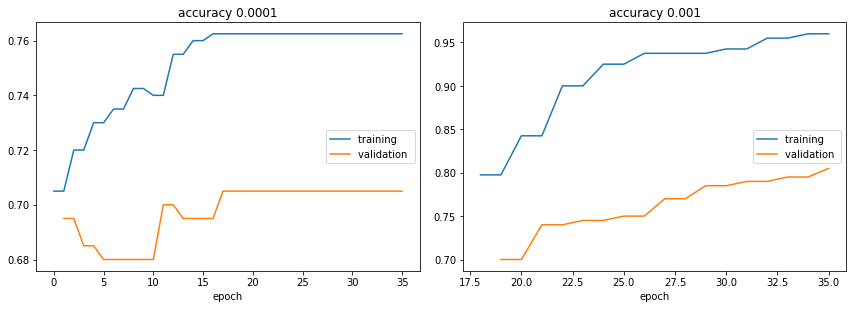

accuracy 0.0001
	training         	 (min:    0.705, max:    0.762, cur:    0.762)
	validation       	 (min:    0.680, max:    0.705, cur:    0.705)
accuracy 0.001
	training         	 (min:    0.797, max:    0.960, cur:    0.960)
	validation       	 (min:    0.700, max:    0.805, cur:    0.805)


In [14]:
layers = [D, 32, 64, 126, 256]
print_every = 1
dropout = 0

def get_parameters_from_model(model):
    parameters_list = list(model.w[1].parameters())
    parameters_list.extend(model.BN[1].parameters())
    parameters_list.extend(model.w[len(layers)].parameters())
    for i in range(2, len(layers)):
        parameters_list.extend(model.w[i].parameters())
        parameters_list.extend(model.BN[i].parameters())
    return parameters_list

liveloss = PlotLosses()
logs = {}

for lr_test in [1e-4, 1e-3]:
    model = FC_network(layers, dropout)
    parameters_list = get_parameters_from_model(model)

    optimizer = torch.optim.SGD(parameters_list, lr=lr_test)
    criterion = nn.CrossEntropyLoss()

    train_FC(logs, model, optimizer, criterion, print_every, liveloss, lr_test)

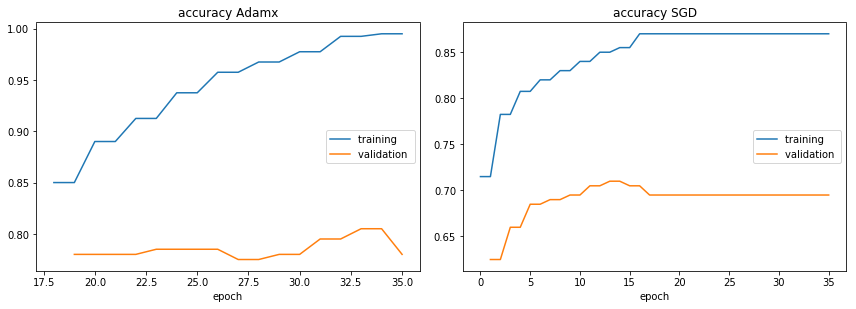

accuracy Adamx
	training         	 (min:    0.850, max:    0.995, cur:    0.995)
	validation       	 (min:    0.775, max:    0.805, cur:    0.780)
accuracy SGD
	training         	 (min:    0.715, max:    0.870, cur:    0.870)
	validation       	 (min:    0.625, max:    0.710, cur:    0.695)


In [15]:
learning_rate= 1e-3
liveloss = PlotLosses()
logs = {}

for optimizer in [torch.optim.SGD, torch.optim.Adamax]:
    if optimizer == torch.optim.SGD:
        cross_val = 'SGD'
    else:
        cross_val = 'Adamx'
    model = FC_network(layers, dropout)
    parameters_list = get_parameters_from_model(model)

    optimizer = optimizer(parameters_list, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_FC(logs, model, optimizer, criterion, print_every, liveloss, cross_val)

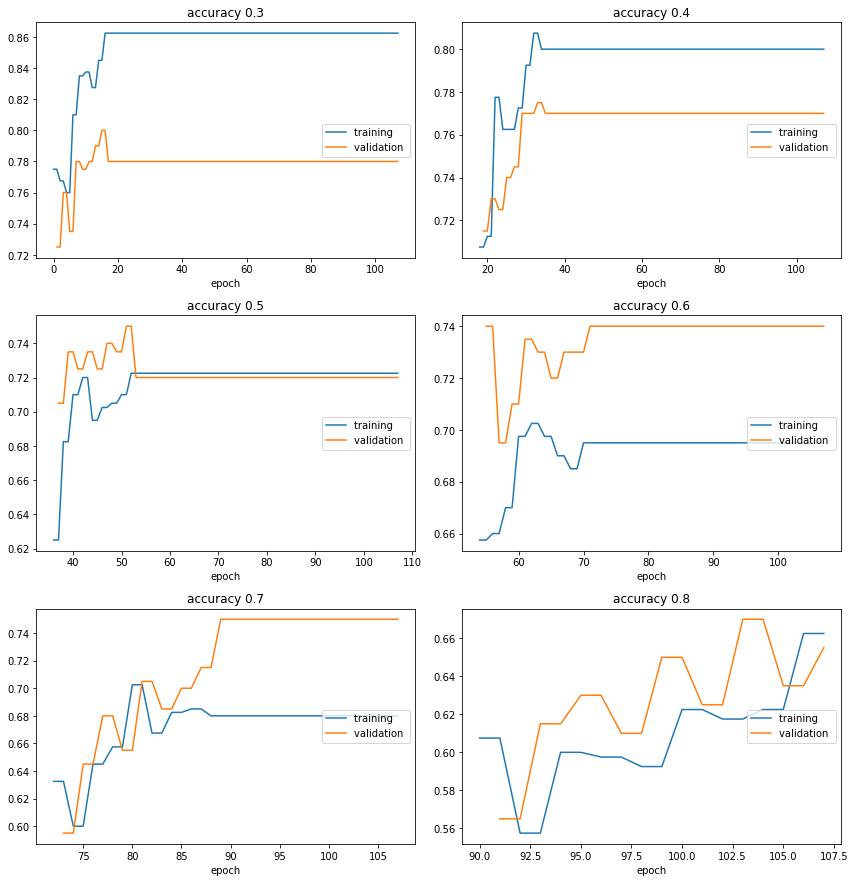

accuracy 0.3
	training         	 (min:    0.760, max:    0.863, cur:    0.863)
	validation       	 (min:    0.725, max:    0.800, cur:    0.780)
accuracy 0.4
	training         	 (min:    0.708, max:    0.807, cur:    0.800)
	validation       	 (min:    0.715, max:    0.775, cur:    0.770)
accuracy 0.5
	training         	 (min:    0.625, max:    0.723, cur:    0.723)
	validation       	 (min:    0.705, max:    0.750, cur:    0.720)
accuracy 0.6
	training         	 (min:    0.657, max:    0.703, cur:    0.695)
	validation       	 (min:    0.695, max:    0.740, cur:    0.740)
accuracy 0.7
	training         	 (min:    0.600, max:    0.703, cur:    0.680)
	validation       	 (min:    0.595, max:    0.750, cur:    0.750)
accuracy 0.8
	training         	 (min:    0.557, max:    0.662, cur:    0.662)
	validation       	 (min:    0.565, max:    0.670, cur:    0.655)


In [16]:
optimizer = torch.optim.Adamax
liveloss = PlotLosses()
logs = {}

for dropout in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    model = FC_network(layers, dropout)
    parameters_list = get_parameters_from_model(model)

    optimiz = optimizer(parameters_list, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_FC(logs, model, optimiz, criterion, print_every, liveloss, dropout)

In [17]:
dropout = 0.75

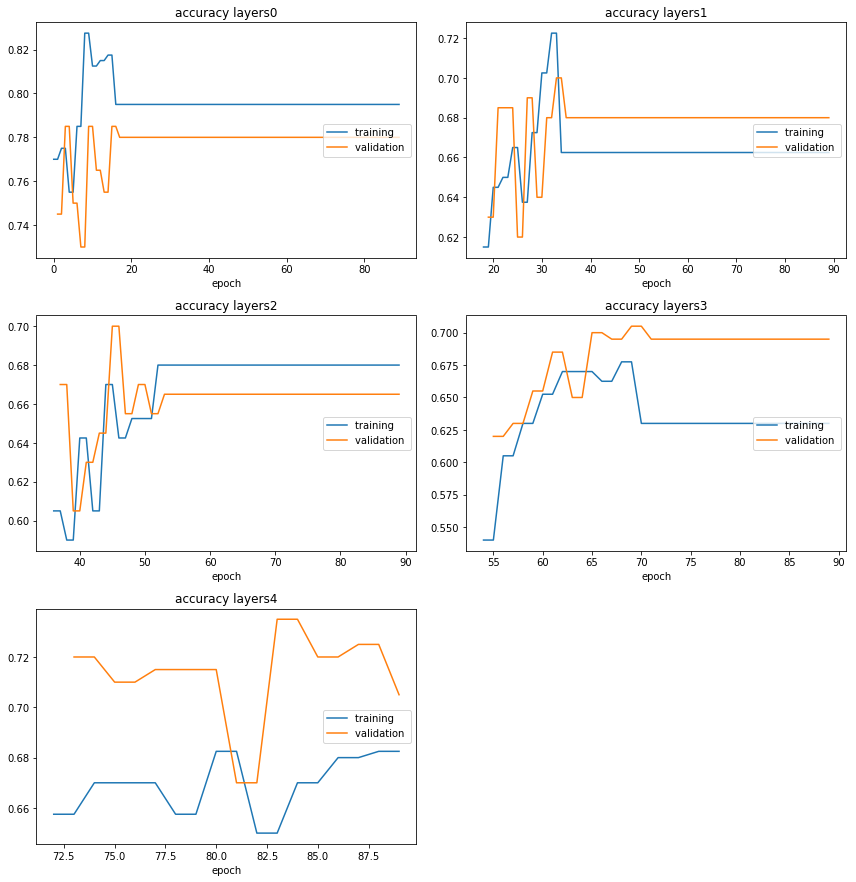

accuracy layers0
	training         	 (min:    0.755, max:    0.828, cur:    0.795)
	validation       	 (min:    0.730, max:    0.785, cur:    0.780)
accuracy layers1
	training         	 (min:    0.615, max:    0.723, cur:    0.662)
	validation       	 (min:    0.620, max:    0.700, cur:    0.680)
accuracy layers2
	training         	 (min:    0.590, max:    0.680, cur:    0.680)
	validation       	 (min:    0.605, max:    0.700, cur:    0.665)
accuracy layers3
	training         	 (min:    0.540, max:    0.677, cur:    0.630)
	validation       	 (min:    0.620, max:    0.705, cur:    0.695)
accuracy layers4
	training         	 (min:    0.650, max:    0.682, cur:    0.682)
	validation       	 (min:    0.670, max:    0.735, cur:    0.705)


In [18]:
layers4 = [D, 32, 64, 128, 256, 1024]
layers3 = [D, 32, 64, 128, 256]
layers2 = [D, 32, 64, 128]
layers1 = [D, 32, 64]
layers0 = [D, 32]

liveloss = PlotLosses()
logs = {}

for layers in [layers0, layers1, layers2, layers3, layers4]:
    if layers == layers0:
        cross_val = 'layers0'
    elif layers == layers1:
        cross_val = 'layers1'
    elif layers == layers2:
        cross_val = 'layers2'
    elif layers == layers3:
        cross_val = 'layers3'
    else:
        cross_val = 'layers4'
    model = FC_network(layers, dropout)
    parameters_list = get_parameters_from_model(model)

    optimiz = optimizer(parameters_list, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_FC(logs, model, optimiz, criterion, print_every, liveloss, cross_val)

## Train the model

In [19]:
layers = layers3
epochs_num = 10

X_data, y_data = load_data(images, int(len(images) / 4))
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(X_data, y_data)

# X_train, y_train = correct_unbalanced_train_data(X_train, y_train)

train_data = data.TensorDataset(X_train, y_train)
val_data = data.TensorDataset(X_val, y_val)
test_data = data.TensorDataset(X_test, y_test)

loader_train = DataLoader(train_data, batch_size=mini_batch_size)
loader_val = DataLoader(val_data, batch_size=mini_batch_size)
loader_test = DataLoader(test_data, batch_size=mini_batch_size)

Train shape: 27752
Test shape: 27753
Val shape: 13876


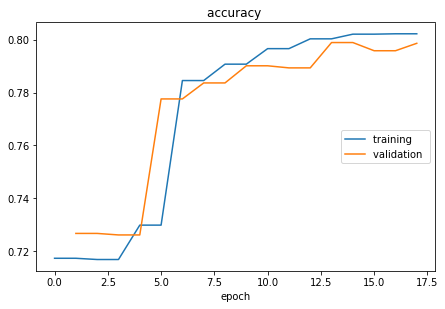

accuracy 
	training         	 (min:    0.717, max:    0.802, cur:    0.802)
	validation       	 (min:    0.726, max:    0.799, cur:    0.799)


In [20]:
model = FC_network(layers, dropout)
parameters_list = get_parameters_from_model(model)

optimiz = optimizer(parameters_list, lr=learning_rate)
criterion = nn.CrossEntropyLoss()
liveloss = PlotLosses()
logs = {}

train_FC(logs, model, optimiz, criterion, print_every, liveloss, '')

Finally, lets check on the test data set:

In [21]:
train_FC(logs, model, optimiz, criterion, print_every, liveloss, dropout, test = True, epochs = epochs_num)

Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977Test acuracy: 0.7977

### Correct the unbalanced data:

In [22]:
def correct_unbalanced_train_data(X_train, y_train):
    neg_indices = [i for i, label in enumerate(y_train) if label == 0]
    pos_indices = [i for i, label in enumerate(y_train) if label == 1]

    print('On train dataset, number of IDC(+): '+str (len(pos_indices)))
    print('On train dataset, number of IDC(-): '+str (len(neg_indices)))

    random_indices = torch.randperm(len(neg_indices), dtype=torch.int64)
    neg = torch.Tensor(neg_indices).long()
    random_indices = neg[random_indices]

    indices = torch.cat((random_indices[0: len(pos_indices)],
                                        torch.tensor(pos_indices, dtype=torch.long)), dim=0)
    per = torch.randperm(indices.size()[0])
    indices = indices[per]

    X_train = X_train[indices] 
    y_train = y_train[indices]

    neg_indices = [i for i, label in enumerate(y_train) if label == 0]
    pos_indices = [i for i, label in enumerate(y_train) if label == 1]

    print('Number of IDC(+): ' + str(len(pos_indices)))
    print('Number of IDC(-): ' + str(len(neg_indices)))
    
    return X_train, y_train

## Three layer CNN
Next, I will implement the following arcitecture:

(CNN -> BN -> ReLU -> max_pool) * 3 -> (FC -> ReLU) * 2 -> softmax

This time, I will use nn.Sequential

In [ ]:
def train(model, optimizer, criterion, time, liveloss, logs, cross_val, num_epochs=10, test=False):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    if test:
        running_corrects = 0
        running_total = 0
        running_loss = 0

        for t, (x_batch, y_batch) in enumerate(loader_test):
            y_batch = y_batch.to(dtype=torch.long)
            x_batch = x_batch.to(dtype=torch.float32)

            scores = model(x_batch)
            loss = criterion(scores, y_batch)

            running_loss += loss
            _, preds = scores.max(1)
            running_corrects += (preds == y_batch).sum()
            running_total += preds.size()[0]
        
        acc = float(running_corrects) / running_total
        print('Test acuracy: %.4f' % acc * 100)

    for epoch in range(0, num_epochs):
        for phase in ['train', 'validation']:
            running_correct = 0
            running_total = 0
            running_loss = 0

            if phase == 'train':
                data = loader_train
            else:
                data = loader_val

            for t, (x_batch, y_batch) in enumerate(data):

                y_batch = y_batch.to(dtype=torch.long, device=device)
                x_batch = x_batch.to(dtype=torch.float32, device=device)

                scores = model(x_batch)

                loss = criterion(scores, y_batch)
                running_loss += loss

                _, preds = scores.max(1)
                running_correct += (preds == y_batch).sum()
                running_total += preds.size()[0]

                if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

            epoch_acc = float(running_correct) / running_total
            epoch_loss = float(running_loss) / running_total

            if epoch % time == 0 and epoch > 0:
                prefix = ''
                if phase == 'validation':
                    prefix = 'val_'
                #logs[prefix + 'loss '+str(cross_val)] = epoch_loss
                logs[prefix + 'accuracy '+str(cross_val)] = epoch_acc
                liveloss.update(logs)
                liveloss.send()

In [24]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 400
learning_rate = 1e-3
print_every = 1

class conv_init(nn.Conv2d):
    def __init(self):
        super.__init__()
        self.weight.data = xavier_normal(m.weight.size())
        self.bias.data = zero_weight(m.bias.size())

Layer1 = nn.Sequential(
    conv_init(3, 16, (5, 5), padding=2),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2)
)

Layer2 = nn.Sequential(
    conv_init(16, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU()
)

Layer3 = nn.Sequential(
    conv_init(32, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(5)
)

model = nn.Sequential(
    Layer1,
    Layer2,
    Layer3,
    Flatten(),
    nn.Linear(64 * 5 * 5, 2),
)

In [25]:
X_data, y_data = load_data(images, 2000)
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(X_data, y_data)

# X_train, y_train = correct_unbalanced_train_data(X_train, y_train)

train_data = data.TensorDataset(X_train, y_train)
val_data = data.TensorDataset(X_val, y_val)
test_data = data.TensorDataset(X_test, y_test)

loader_train = DataLoader(train_data, batch_size=mini_batch_size)
loader_val = DataLoader(val_data, batch_size=mini_batch_size)
loader_test = DataLoader(test_data, batch_size=mini_batch_size)

Train shape: 800
Test shape: 800
Val shape: 400


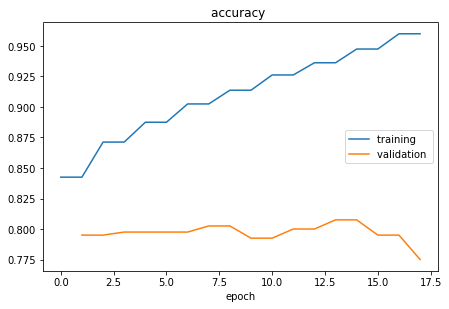

accuracy 
	training         	 (min:    0.717, max:    0.960, cur:    0.960)
	validation       	 (min:    0.726, max:    0.807, cur:    0.775)


In [26]:
optimiz = optimizer(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
liveloss = PlotLosses()
logs = {}

train(model, optimiz, criterion, print_every, liveloss, logs, '')

## Dropout regularization

In order to eliminate the 

In [27]:
X_data, y_data = load_data(images, int(len(images) / 5))
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(X_data, y_data)

# X_train, y_train = correct_unbalanced_train_data(X_train, y_train)

train_data = data.TensorDataset(X_train, y_train)
val_data = data.TensorDataset(X_val, y_val)
test_data = data.TensorDataset(X_test, y_test)

loader_train = DataLoader(train_data, batch_size=mini_batch_size)
loader_val = DataLoader(val_data, batch_size=mini_batch_size)
loader_test = DataLoader(test_data, batch_size=mini_batch_size)

Train shape: 22201
Test shape: 22203
Val shape: 11100


In [28]:
def Layer(dropout, in_channel, out_channel, kernel, padding):
    return nn.Sequential(
    conv_init(in_channel, out_channel, (kernel, kernel), padding=padding),
    nn.Dropout(p=dropout),
    nn.BatchNorm2d(out_channel),
    nn.ReLU(),
    nn.MaxPool2d(2))

model = nn.Sequential(
    Layer(0.7, 3, 32, 3, 2),
    Layer(0.5, 32, 64, 3, 2),
    Layer(0.5, 64, 128, 3, 2),
    Layer(0.6, 128, 256, 3, 2),
    Flatten(),
    nn.Linear(256 * 5 * 5, 2))

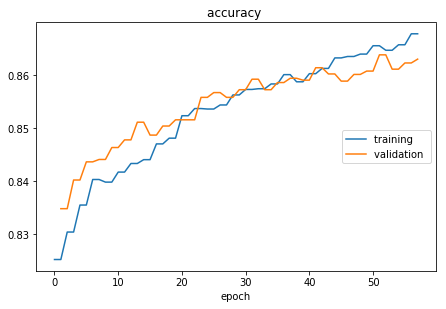

accuracy 
	training         	 (min:    0.717, max:    0.960, cur:    0.868)
	validation       	 (min:    0.726, max:    0.864, cur:    0.863)


In [29]:
optimiz = optimizer(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
liveloss = PlotLosses()
logs = {}

train(model, optimiz, criterion, print_every, liveloss, logs, '', num_epochs=30)

In [ ]:
train(model, optimiz, criterion, print_every, liveloss, logs, '', num_epochs=30, test = True)